<a href="https://colab.research.google.com/github/evefine/useful_personal/blob/main/budgeting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tkinter as tk
import os
from tkinter import simpledialog
import csv
from datetime import datetime
from tkinter import ttk
from tkinter import messagebox
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import numpy as np
from dateutil.relativedelta import relativedelta

In [ ]:
def new_budgets_window(root):
    # Create new window
    budget_window = tk.Toplevel(root)
    #budget_window.geometry("500x300")
    budget_window.title("Budgeting GUI - New Budgets")

    # Create a frame for the budgets
    budget_frame = tk.Frame(budget_window)
    budget_frame.pack(side="top", pady=10)

    # Create entries for each budget
    budget_entries = []
    for i in range(10):
        # Create a label and entry for the budget name
        name_label = tk.Label(budget_frame, text="Budget Name:")
        name_label.grid(row=i, column=0, padx=10, pady=10)
        name_entry = tk.Entry(budget_frame)
        name_entry.grid(row=i, column=1, padx=10, pady=10)

        # Create a label and entry for the budget amount
        amount_label = tk.Label(budget_frame, text="Budget Amount:")
        amount_label.grid(row=i, column=2, padx=10, pady=10)
        amount_entry = tk.Entry(budget_frame)
        amount_entry.grid(row=i, column=3, padx=10, pady=10)

        # Add the budget entries to the list
        budget_entries.append((name_entry, amount_entry))

    # Create a button to submit the budgets
    def submit_budgets(budget_window, budget_entries):
        # Create list of budget tuples
        budgets = []
        names = []
        for entry in budget_entries:
            name = entry[0].get().strip()
            amount_str = entry[1].get().strip()
            if not amount_str:
                amount = 0
            else:
                amount = int(amount_str)
            if name and amount:
                budgets.append((name, amount))
                names.append(name)
    
        # Prompt user for filename and save budgets CSV
        title = simpledialog.askstring("Save File", "Please enter the filename to save your budgets as (do not include file extension):", parent=budget_window)
        with open(title+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["budget", "amount"])
            writer.writerows(budgets)
    
        # Create purchases csv with columns for each budget
        purchases_title = title+'_purchases.csv'
        with open(purchases_title, 'w', newline='') as file:
            writer = csv.writer(file)
            headers = [budget[0] for budget in budgets]
            writer.writerow(headers)
    
        # close the budget window
        budget_window.destroy()

    submit_button = tk.Button(budget_frame, text="Submit", command=lambda: submit_budgets(budget_window, budget_entries))
    submit_button.grid(row=11, column=1, pady=10)
    
    # Keep the budgets window open until it is closed
    budget_window.mainloop()

In [ ]:
def get_budgets_from_csv(filename):
    # Opens the csv file with the given filename in read mode
    with open(filename, 'r') as file:
        # Initializes a csv reader object to read the file
        reader = csv.reader(file)
        # Skips the first row of the csv file, which is assumed to contain headers
        headers = next(reader)
        # Returns the headers as a list
        return headers

def get_budget_files():
    # Get a list of all files in the current directory
    files = os.listdir('.')
    
    # Create an empty list to store the names of budget files
    budget_files = []
    
    # Loop through each file in the directory
    for file in files:
        # Check if the file ends with '.csv' and does not end with '_purchases.csv'
        if file.endswith('.csv') and not file.endswith('_purchases.csv'):
            # If the file meets these conditions, add its name (minus the '.csv' extension) to the list of budget files
            budget_files.append(file[:-4])
    
    # Return the list of budget file names
    return budget_files

In [ ]:
def open_budget_window():
    # Get a list of available budget files
    budget_files = get_budget_files()

    # Check if there are any budget files available
    if not budget_files:
        # Display a warning message if there are no budget files and return
        messagebox.showwarning("No budgets found", "No budgets found. Please create a budget first.")
        return

    # Create a new window for selecting the budget file to open
    budget_window = tk.Toplevel(root)
    budget_window.title("Select Budget")

    # Add a label to the window prompting the user to select a budget
    tk.Label(budget_window, text="Please select a budget to view or edit:").pack()

    # Create a variable for the selected budget and set it to the first budget file in the list
    selected_budget = tk.StringVar()
    selected_budget.set(budget_files[0])

    # Create a dropdown menu with the available budget files and set the default value to the first budget file
    ttk.OptionMenu(budget_window, selected_budget, *budget_files).pack()

    # Define functions to handle the view, add, and edit buttons
    def view_budget():
        # Destroy the current window and open the view purchase window for the selected budget
        budget_window.destroy()
        open_view_purchase_window(selected_budget.get())

    def add_purchase():
        # Destroy the current window and open the add purchase window for the selected budget
        budget_window.destroy()
        open_add_purchase_window(selected_budget.get())

    def edit_budget():
        # Destroy the current window and open the edit budget window for the selected budget
        budget_window.destroy()
        open_edit_budget_window(selected_budget.get())

    # Create buttons for each function and pack them into the window
    view_button = tk.Button(budget_window, text="View Budget", command=view_budget)
    view_button.pack(pady=10)

    add_button = tk.Button(budget_window, text="Add Purchase", command=add_purchase)
    add_button.pack(pady=10)

    edit_button = tk.Button(budget_window, text="Edit Budget", command=edit_budget)
    edit_button.pack(pady=10)

    cancel_button = tk.Button(budget_window, text="Cancel", command=budget_window.destroy)
    cancel_button.pack(pady=10)

    # Return the created window
    return

In [ ]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

def previous_month(num_months):
    return (datetime.now() + relativedelta(months=-num_months)).strftime("%m/%Y")

def get_spending_data(budget_filename, date):
    budget_csv = budget_filename + '.csv'
    purchases_csv = budget_filename + '_purchases.csv'
    minibudgets = get_budgets_from_csv(purchases_csv)
    
    # Read the original csv file and store the information in a dictionary
    with open(budget_csv, "r") as budget_file:
        reader = csv.reader(budget_file)
        next(reader)  # skip header
        budget_dict = {row[0]: float(row[1]) for row in reader}
    
    # Read the purchases csv file and store the information in a dictionary
    with open(purchases_csv, "r") as purchase_file:
        reader = csv.reader(purchase_file)
        df = pd.read_csv(purchase_file)
        purchases_dict = {}
        for minibudget in minibudgets:
            purchases_dict[minibudget] = []
            for _, entry in df[minibudget].iteritems():
                if pd.notnull(entry) and date in entry:
                    purchases_dict[minibudget].append(entry.split('|'))

    minibudget_spent_dict = {minibudgets[0]:0,
                            minibudgets[1]:0}
    
    # Calculate the total spent for each minibudget
    for minibudget in minibudgets:
        total_spent = 0
        for entry in purchases_dict[minibudget]:
            total_spent += float(entry[0])
        minibudget_spent_dict[minibudget] = total_spent
        
    # Calculate the remaining amount for each minibudget
    remaining_dict = {}
    for minibudget, amount in budget_dict.items():
        remaining_dict[minibudget] = amount - minibudget_spent_dict[minibudget]
    
    return minibudget_spent_dict, remaining_dict, budget_dict

def open_view_purchase_window(budget_filename,date=None):
    budget_csv = budget_filename + '.csv'
    purchases_csv = budget_filename + '_purchases.csv'
    minibudgets = get_budgets_from_csv(purchases_csv)
    
    # See if the user wants to see the current date or a previous date
    if not date:
        now = datetime.now()
        date = now.strftime("%m/%Y")

    # Create the tkinter window
    view_window = tk.Toplevel()
    view_window.title("View Budget "+ date)
    
    minibudget_spent_dict, remaining_dict, budget_dict = get_spending_data(budget_filename, date)
    
    # display the remaining amount for each minibudget in a tkinter Label
    tk.Label(view_window, text="Remaining Amount for Each Minibudget").grid(row=0, column=0, columnspan=2)
    for i, (minibudget, remaining_amount) in enumerate(remaining_dict.items()):
        tk.Label(view_window, text=f"{minibudget}: ${remaining_amount:.2f}").grid(row=i+1, column=1)
    
    colors_graph = []
    
    # Get lists of values to be used later
    minibudget_labels = list(budget_dict.keys())
    minibudget_values = list(budget_dict.values())
    spent_amounts = list(minibudget_spent_dict.values())
    
    # Create labels and colors for the graph
    for i in range(len(spent_amounts)):
        minibudget_labels[i] += '\n $' + str(spent_amounts[i])
        colors_graph.append('#d95f02')

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set the x-axis labels and positions
    x_pos = np.arange(len(minibudget_labels))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(minibudget_labels)

    # Create the bars
    ax.bar(x_pos, spent_amounts, label='Spent',color=colors_graph)
    ax.bar(x_pos, minibudget_values, alpha=0.5, label='Budget',color=colors_graph)

    # Add the legend
    ax.legend()

    # Add the labels and title
    ax.set_xlabel('Minibudget')
    ax.set_ylabel('Dollars')
    ax.set_title('Spending Breakdown by Minibudget')
    
    # Add figure to the tkinter window
    canvas = FigureCanvasTkAgg(fig, master=view_window)
    canvas.draw()
    canvas.get_tk_widget().grid(row=0, column=2, rowspan=len(remaining_dict)+1)

    
    # Allow user to select a different month to view budget data
    tk.Label(view_window, text="See a different month (MM/YYYY)").grid(row=len(remaining_dict.items())-2, column=0)
    new_date = tk.Entry(view_window)
    new_date.grid(row=len(remaining_dict.items())-1,column=0)
    
    # Allow user to see trends
    tk.Label(view_window, text="See trends over __ months").grid(row=len(remaining_dict.items())+1, column=0)
    how_many_months = tk.Entry(view_window)
    how_many_months.grid(row=len(remaining_dict.items())+1,column=1)
    
    def new_month():
        view_window.destroy
        open_view_purchase_window(budget_filename, date=new_date.get())
    
    def view_trends():
        view_window.destroy
        open_trend_window(budget_filename, int(how_many_months.get()))
    
    # User can input a different month to view
    new_date_button = tk.Button(view_window, text="View",command=new_month)
    new_date_button.grid(row=len(remaining_dict.items()),column=0)
    
    trend_button = tk.Button(view_window, text="View",command=view_trends)
    trend_button.grid(row=len(remaining_dict.items())+2,column=2)

    
def open_trend_window(budget_filename, num):
    budget_csv = budget_filename + '.csv'
    purchases_csv = budget_filename + '_purchases.csv'
    minibudgets = get_budgets_from_csv(purchases_csv)
    
    # Set up new window
    trend_window = tk.Toplevel()
    trend_window.title("View Budget Trends")
    
    # Initialize trend lists
    trend_data_spent = []
    trend_data_remaining = []
    for _ in range(len(minibudgets)):
        trend_data_spent.append([])
        trend_data_remaining.append([])
    dates = []
    
    # Get spending data and remaining data for all minibudgets for each month
    for i in range(num):
        remaining = []
        spent = []
        date = previous_month(i)
        dates.append(date)
        minibudget_spent_dict, remaining_dict, _ = get_spending_data(budget_filename, date)

        for j,minibudget in enumerate(minibudgets):
            trend_data_spent[j].append(minibudget_spent_dict[minibudget])
            trend_data_remaining[j].append(remaining_dict[minibudget])
    
    # Reverse so going chronologically
    dates.reverse()
    
    # Colors for graph
    colors_graph = []
    for i in range(len(minibudgets)):
        colors_graph.append(colors[i%len(colors)])

    # Set up figures
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    fig2, ax2 = plt.subplots(figsize=(7, 5))
    figs = [fig1, fig2]
    axs = [ax1, ax2]
    
    # Set the x-axis labels and positions
    x_pos = np.arange(len(dates))
    for ax in axs:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(dates)
    datas = [trend_data_spent,trend_data_remaining]
    
    # Reverse data so chronological
    for i in range(2):
        for j in range(len(datas[i])):
            datas[i][j].reverse()
            
    # Create the lines
    for i,ax in enumerate(axs):
        data = datas[i]
        for i,lst in enumerate(data):
            ax.plot(x_pos, lst, label=minibudgets[i],color=colors_graph[i])
    
    
    # Add the legend
    for ax in axs:
        ax.legend(loc='upper left')

    # Add the labels and title
    for i,ax in enumerate(axs):
        ax.set_xlabel('Date')
        if i ==0:
            ax.set_ylabel('Dollars Spent')
            ax.set_title('Spending Breakdown Over months')
        else:
            ax.set_ylabel('Dollars Remaining')
            ax.set_title('Remaining Breakdown Over months')
    
    # Add figure to the tkinter window
    for i,fig in enumerate(figs):
        canvas = FigureCanvasTkAgg(fig, master=trend_window)
        canvas.draw()
        canvas.get_tk_widget().grid(row=0, column=i, rowspan=len(remaining_dict)+1)
        

In [ ]:
def open_add_purchase_window(budget_filename):
    # Get the list of minibudgets from the purchases CSV file
    minibudgets = get_budgets_from_csv(budget_filename + '_purchases.csv')
    
    # If there are no minibudgets found, display a warning message and return
    if not minibudgets:
        messagebox.showwarning("No budgets found", "No budgets found in file. Please create a budget first.")
        return

    # Create a new window to add a purchase
    purchase_window = tk.Toplevel(root)
    purchase_window.title("Add Purchase")

    # Add labels and entry fields for selecting minibudget, entering amount, description, and date
    tk.Label(purchase_window, text="Select minibudget:").grid(row=1, column=0)
    tk.Label(purchase_window, text="Enter amount ($):").grid(row=2, column=0)
    tk.Label(purchase_window, text="Enter description:").grid(row=3, column=0)
    tk.Label(purchase_window, text="Enter date (MM/YYYY):").grid(row=4,column=0)
    
    # Set the first minibudget as the default selected minibudget
    selected_minibudget = tk.StringVar()
    selected_minibudget.set(minibudgets[0])

    # Create a dropdown menu to select the minibudget
    minibudget_dropdown = ttk.OptionMenu(purchase_window, selected_minibudget, *minibudgets)
    minibudget_dropdown.grid(row=1, column=1)

    # Create an entry field for entering the purchase amount
    amount = tk.Entry(purchase_window)
    amount.grid(row=2, column=1)

    # Create an entry field for entering the purchase description
    description = tk.Entry(purchase_window)
    description.grid(row=3, column=1)

    # Set the default date as the current month and year
    now = datetime.now()
    default_text = tk.StringVar(value=now.strftime("%m/%Y"))

    # Create an entry field for entering the purchase date
    date = tk.Entry(purchase_window,textvariable=default_text)
    date.grid(row=4, column=1)

    def add_purchase():
        # Create a list to hold purchase information for each minibudget
        info = list(['']*len(minibudgets))
    
        # Get the index of the selected minibudget
        selected_index = minibudgets.index(selected_minibudget.get())
    
        # Add the amount, date, and description of the purchase to the selected minibudget's info list
        info[selected_index] = str(amount.get())+'|'+str(date.get())+'|'+str(description.get())
    
        # Write the purchase information to the purchases file for the budget
        with open(budget_filename + '_purchases.csv', 'a', newline='') as purchase_file:
            writer = csv.writer(purchase_file)
            writer.writerow(info)
    
        # Show a message confirming that the purchase was added and destroy the purchase window
        messagebox.showinfo("Purchase added", f"Purchase of {amount.get()} from minibudget {selected_minibudget.get()} added.")
        purchase_window.destroy()

    # Create an "Add" button to add the purchase
    add_button = tk.Button(purchase_window, text="Add", command=add_purchase)
    add_button.grid(row=5,column=0)

In [ ]:
def open_edit_budget_window(budget_filename):
    budget_csv = budget_filename + '.csv'
    purchases_csv = budget_filename + '_purchases.csv'
    minibudgets = get_budgets_from_csv(purchases_csv)

    # Create the tkinter window
    edit_window = tk.Toplevel()
    edit_window.geometry("800x800")
    edit_window.title("Edit Budget")
    
    # Read in commonly used values
    budget_df = pd.read_csv(budget_csv)
    minibudgets = list(budget_df['budget'].values)
    amounts = list(budget_df['amount'].values)
    
    # Create a frame for the budgets
    edit_frame = tk.Frame(edit_window)
    edit_frame.pack(side="top", pady=10)

    # Create entries for each budget
    budget_entries = []
    names = []

    for i in range(10):
        if i < len(minibudgets):
            # Prefill the entries with the existing budget data
            default_name = tk.StringVar(value=minibudgets[i])
            default_amt = tk.StringVar(value=amounts[i])
        else:
            default_name = tk.StringVar(value=None)
            default_amt = tk.StringVar(value=None)

        # Create a label and entry for the budget name
        name_label = tk.Label(edit_frame, text="Budget Name:")
        name_label.grid(row=i, column=0, padx=10, pady=10)
        name_entry = tk.Entry(edit_frame,textvariable=default_name)
        name_entry.grid(row=i, column=1, padx=10, pady=10)

        # Create a label and entry for the budget amount
        amount_label = tk.Label(edit_frame, text="Budget Amount:")
        amount_label.grid(row=i, column=2, padx=10, pady=10)
        amount_entry = tk.Entry(edit_frame,textvariable=default_amt)
        amount_entry.grid(row=i, column=3, padx=10, pady=10)

        # Add the budget entries to the list
        budget_entries.append((name_entry, amount_entry))

    
    # Create a button to submit the budgets
    def submit_budgets(budget_window):
        # Create list of budget tuples
        budgets = []
        names = []
        for entry in budget_entries:
            name = entry[0].get().strip()
            amount_str = entry[1].get().strip()
            if not amount_str:
                amount = 0
            else:
                amount = int(amount_str)
            if name and amount:
                budgets.append((name, amount))
                names.append(name)
        
        # Save budgets CSV
        with open(budget_filename+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["budget", "amount"])
            writer.writerows(budgets)
        
        # Check for if any minibudgets were lost/gained
        new_rows = []
        new_names = []
        lost_names = []
        purchases_df = pd.read_csv(purchases_csv)
    
        # Find lost minibudgets
        for name in minibudgets:
            if name not in names:
                lost_names.append(name)
        
        # Get rid of lost minibudgets in the purchases file
        purchases_df.drop(columns=lost_names,inplace=True)
        os.remove(purchases_csv)
        purchases_df.to_csv(purchases_csv,index=False)

        # Find new minibudgets
        for name in names:
            if name not in minibudgets:
                new_names.append(name)
        
        # Add new minibudgets to purchases file
        with open(purchases_csv) as file:
            reader_obj = csv.reader(file)
            for i,row in enumerate(reader_obj):
                if i == 0:
                    new_rows.append(row + new_names)
                else:
                    new_rows.append(row + [] * len(new_names))
        os.remove(purchases_csv)
        with open(purchases_csv, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(new_rows)

        # Close the budget window
        budget_window.destroy()
        
    # Create a submit button
    submit_button = tk.Button(edit_frame, text="Submit", command=lambda: submit_budgets(edit_window))
    submit_button.grid(row=11, column=1, pady=10)
    

minibudgets ['Rent', 'Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
minibudgets ['Rent', 'Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
minibudgets ['Rent', 'Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
minibudgets ['Rent', 'Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
10
 
Utilities 100
Transportation 100
Groceries 300
Eating out/Coffee 100
Monthly trip 400
Other Expenses 200
 
 
 
budgets [('Utilities', 100), ('Transportation', 100), ('Groceries', 300), ('Eating out/Coffee', 100), ('Monthly trip', 400), ('Other Expenses', 200)]
row ['Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
new_names []
new [['Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses'], ['', '', '', '', '', ''], ['80|

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/evefine/opt/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-49-56cfb76932e4>", line 29, in view_budget
    open_view_purchase_window(selected_budget.get())
  File "<ipython-input-61-8d1f0ada7607>", line 60, in open_view_purchase_window
    minibudget_spent_dict, remaining_dict, budget_dict = get_spending_data(budget_filename, date)
  File "<ipython-input-61-8d1f0ada7607>", line 30, in get_spending_data
    minibudgets[1]:0}
IndexError: list index out of range


minibudgets ['Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
minibudgets ['Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']
minibudgets ['Utilities', 'Transportation', 'Groceries', 'Eating out/Coffee', 'Monthly trip', 'Other Expenses']


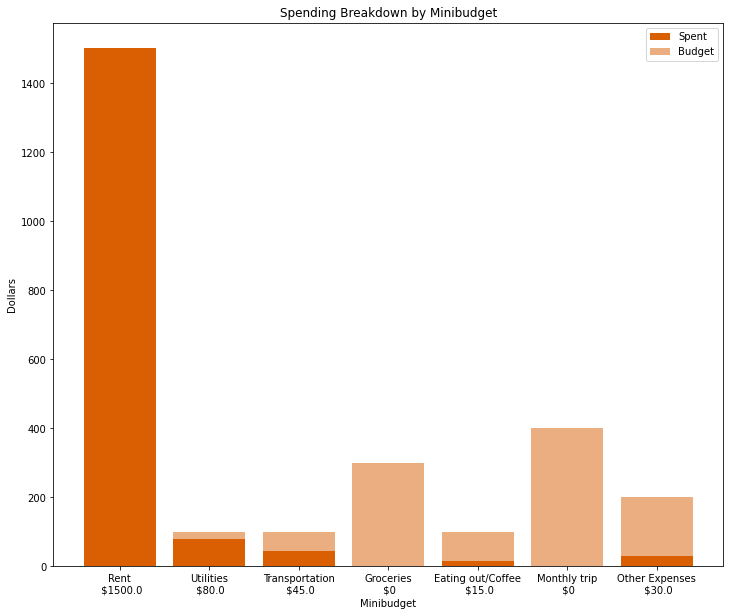

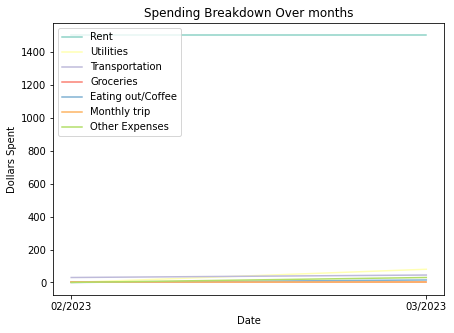

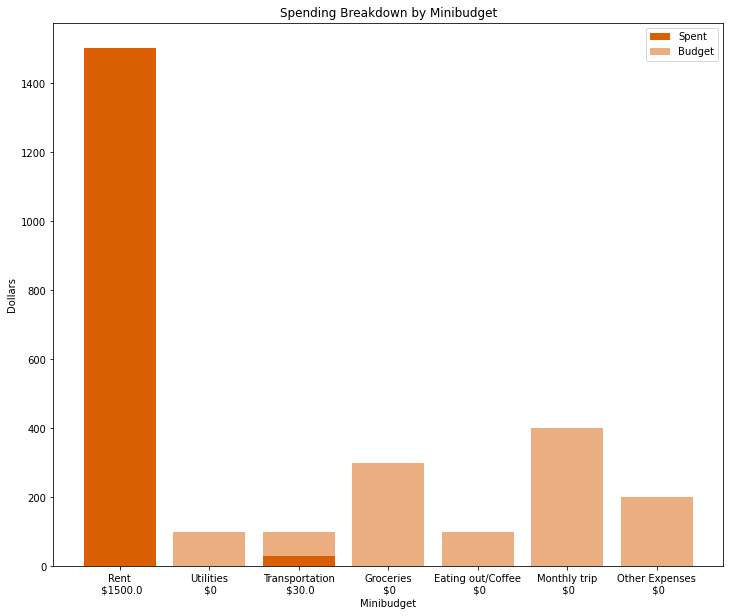

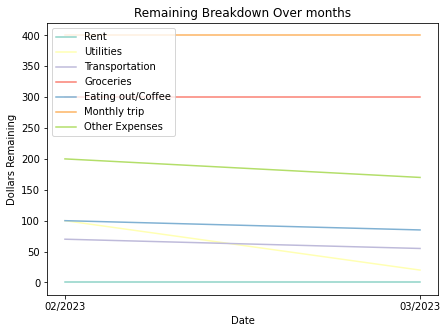

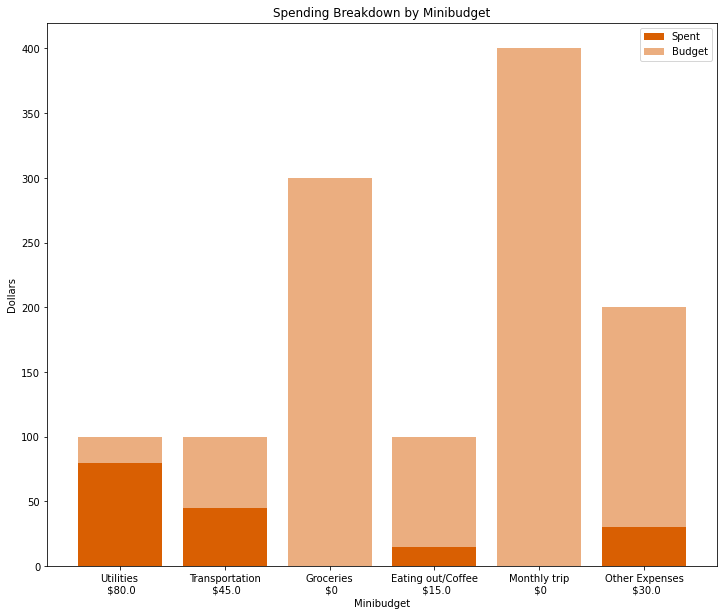

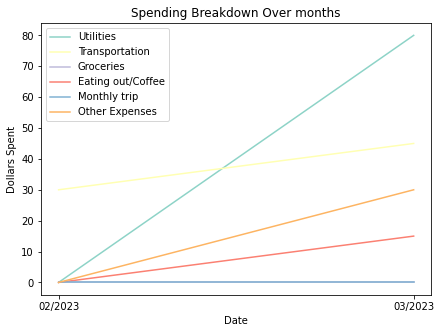

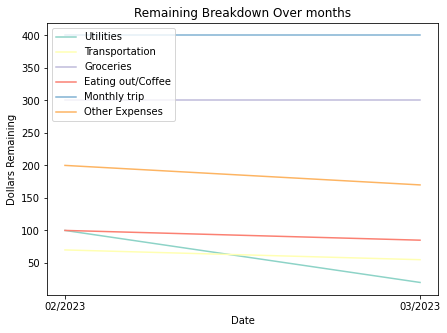

In [ ]:
def start_page():
    # Create the main window
    root = tk.Tk()
    root.geometry("500x300")
    root.title("Budgeting GUI")
    # Create a label
    label = tk.Label(root, text="Select whether you'd like to continue \n an existing budget or create a new profile:")
    label.pack(pady=10)
    # Create a frame for the buttons
    button_frame = tk.Frame(root)
    button_frame.pack(side="left", pady=10, fill="both", expand=True)

    # Add buttons to the frame
    button1 = tk.Button(button_frame, text="Create a new profile",command=lambda:new_budgets_window(root))
    button1.place(relx=0.33, rely=0.4, anchor="center")

    button2 = tk.Button(button_frame, text="Continue existing",command=open_budget_window)
    button2.place(relx=0.66, rely=0.4, anchor="center")

    # Start the main event loop
    return root


root = start_page()
root.mainloop()

In [ ]:
def a_day_in_previous_month(dt, num_months):
    return (dt + relativedelta(months=-num_months)).strftime("%m/%Y")


        
try_date = datetime.now()

time = a_day_in_previous_month(try_date, 2)

pd.to_datetime(time)

Timestamp('2023-01-01 00:00:00')

[[]]

[[3, 2, 1], [6, 5, 4]]